# **Feature Bagging for Outlier Detection**

El algoritmo de **Feature Bagging** es una técnica de aprendizaje automático que combina múltiples modelos para mejorar la precisión y robustez de las predicciones. A diferencia del **Bagging** tradicional, que se basa en la creación de subconjuntos aleatorios de datos, el **Feature Bagging** se centra en la selección aleatoria de características (*features*) para entrenar cada modelo.


De aqui se basa el **Feature Bagging** para la detección de anomalías o *outliers*, que utiliza múltiples modelos entrenados en subconjuntos aleatorios de características o *features* . Dado que muchas técnicas de detección de valores atípicos que calculan distancias dimensionales completas también son de naturaleza local, son sensibles a la selección de características utilizadas en el cálculo de distancias. Además, la presencia de características ruidosas e irrelevantes puede reducir significativamente el rendimiento de la detección de valores atípicos , el ensablaje de múltiples modelos entrenados en subconjuntos aleatorios de características puede ayudar a mitigar este problema , ademas , brindando dos formas de agregación de los factores de decisión mas acorde al problema

## Implementación
La implementación realizada en *PyOD_ADGE* , se baso unicamente en el uso del algoritmo de *Local Outlier Factor* (*LOF*) como modelo base, pero , se debe destacar que eso no impide que se pueda extender a otros algoritmos de detección de anomalías. El algoritmo de *LOF* es un método basado en la densidad que mide la densidad local de un punto en comparación con sus vecinos cercanos. Se utiliza comúnmente para detectar puntos atípicos en conjuntos de datos multidimensionales. 

El modelo base , tiene tal cual sus tres modos :
- ```classic``` : sigue el método propuesto en el paper original
- ```optimize``` : método clasico , pero , optimizando la busqueda de *k-neighbors* paralizando el proceso
- ```sklearn``` : utiliza el modelo de *sklearn* para la detección de anomalías ```sklearn.neighbors.LocalOutlierFactor```

### Hiperparámetros
| Parámetro         | Tipo                  | Valor por defecto | Descripción                                                                                               |
|-------------------|-----------------------|-------------------|-----------------------------------------------------------------------------------------------------------|
| `base_estimator`  | `str`                 | `'classic'`       | Tipo de implementació­n de LOF a usar:  `classic` = propia versión,  `sklearn` = la de scikit-learn.     |
| `n_estimators`    | `int`                 | `10`              | Número de “sub-modelos” (estimadores) a entrenar sobre distintos subconjuntos de features.                 |
| `contamination`   | `float`               | `0.1`             | Proporción esperada de outliers en los datos (entre 0 y 0.5).                                             |
| `combine`         | `str`                 | `'breadth'`       | Método para combinar los scores de los estimadores:  `'breadth'` (breadth-first ranking) o `'Cumulative'`.|
| `n_jobs`          | `int`                 | `2`               | Número de procesos paralelos para el entrenamiento (`joblib.Parallel`).                                   |
| `random_state`    | `int` or `None`       | `None`            | Semilla inicial para el generador de números aleatorios; asegura reproducibilidad.                       |
| `n_neighbors`     | `int`                 | `20`              | Parámetro *k* de LOF: número de vecinos a considerar para calcular la densidad local / outlier score.     |
| `metric`          | `str`                 | `'euclidean'`     | Métrica de distancia a usar en LOF (p.ej. `'euclidean'`, `'manhattan'`, etc.).                            |
| `metric_params`   | `dict`                | `{}`              | Parámetros adicionales específicos de la métrica (e.g. `p` para `'minkowski'`, etc.).                     |


## Demo 
Para mostrar el funcionamiento del algoritmo , se usara el dataset [Dataset de Credit Card Fraud de Kaggle](https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud) , que contiene transacciones de tarjetas de crédito, donde la mayoría son transacciones legítimas y una pequeña fracción son fraudulentas. El objetivo es detectar estas transacciones fraudulentas (outliers) en función de las características de las transacciones , esto quiere decir que se pretende de una manera no supervisada obtener ```fraud```.

### Cargar librerías necesarias


In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import sys, os
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.decomposition import PCA
plt.style.use('ggplot')
sns.set_context('notebook')


proj_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)
    
from PyOD_ADGE.models.feature_bagging import FeatureBagging

### Cargando el dataset
Se tomara un muestra estratificada de 10000 filas del dataset, pero se puede usar el dataset completo sin problemas, ya que el algoritmo es escalable y no tiene problemas de memoria. 

In [2]:
url_data='https://drive.google.com/uc?export=download&id=1jGJ-Bam7dR9vH4Y6-677LNNpW-PulLfL'
data=pd.read_csv(url_data,header=0)
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [3]:
data.shape

(1000000, 8)

In [4]:
data['fraud']=data['fraud'].astype(np.int8)
data['fraud'].value_counts()

fraud
0    912597
1     87403
Name: count, dtype: int64

In [5]:
X_f=data.drop(['fraud'],axis=1)
y_f=data['fraud']
X,_,y,_= train_test_split(X_f,y_f,stratify=y_f,train_size=3000,random_state=42)

In [6]:
y.value_counts()

fraud
0    2738
1     262
Name: count, dtype: int64

In [7]:
X=StandardScaler().fit_transform(X)

In [8]:
X.mean(axis=0)

array([ 3.84877315e-17,  2.36847579e-18,  7.99360578e-17,  5.26985862e-17,
        4.50010399e-17, -5.68434189e-17,  2.27965794e-17])

### Instanciar el modelo y entrenar
Al instanciar el modelo , el método ```fit``` se encargara de realizar el ajuste de los modelos base y el ajuste de los hiperparámetros. 


In [9]:
X.shape

(3000, 7)

Instanciamos el modelo con los hiperparámetros deseados y ajustamos con las *features* del dataset.

In [10]:
model=FeatureBagging(n_estimators=5,n_jobs=-1,random_state=42)
model.fit(X)

Con la propuedad ```.outlier_factor_``` , se puede obtener el *local outlier factor* de cada una de las filas del dataset, y con la propiedad , esto recordando que con el modo ```classic``` los resultados son cercanos , iguales o mayores a 1 , con el modo ```sklearn``` los resultados son cercanos a 0 ya que resultaran negativos.

In [11]:
model.outlier_factor_[:13]

array([1.00078731, 1.00969002, 0.97731671, 0.98577794, 0.97714505,
       1.01106486, 0.99951585, 1.06451863, 1.05476186, 0.98684629,
       1.01342764, 0.96873123, 1.00600063])

Con el método ```decision_function``` se obtiene el *label* que el algoritmo le asigna a cada fila, donde -1 es un outlier y 1 es un inlier. 

In [ ]:
ypred=model.decision_function()

In [14]:
ypred_cm=ypred.copy()
ypred_cm=np.where(ypred==1,0,1)

In [15]:
np.unique(ypred_cm,return_counts=True)

(array([0, 1]), array([2700,  300], dtype=int64))

In [16]:
np.unique(y,return_counts=True)

(array([0, 1], dtype=int8), array([2738,  262], dtype=int64))

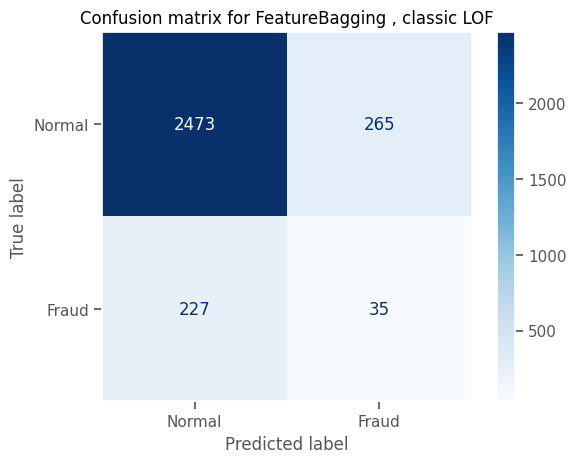

In [17]:
cm=confusion_matrix(y,ypred_cm)
fig,ax=plt.subplots()
disp=ConfusionMatrixDisplay(cm,display_labels=['Normal','Fraud'])
disp.plot(cmap='Blues',ax=ax,colorbar=True)
ax.set_title('Confusion matrix for FeatureBagging , classic LOF')
ax.grid(False)
plt.show()

Ahora se prueba con el modo ```sklearn``` y el modo de combinación ```cumulative``` , ademas , aunmentando el número de estimadores a 20. 

In [55]:
model2=FeatureBagging('sklearn',n_estimators=20,n_neighbors=10,combine='cumulative',metric='cosine',n_jobs=-1,random_state=42)
model2.fit(X)

El método ```cumulative``` , no devuelve el *local outlier factor* en un rango especifico , depende del número de estimadores que se usen

In [56]:
model2.outlier_factor_[:13]

array([-22.20024034, -32.37060537, -24.86592255, -27.74295783,
       -22.13505204, -21.99414896, -21.00263025, -24.66550341,
       -23.61900974, -23.28449119, -23.06917738, -21.43380445,
       -22.76761563])

In [57]:
ypred2=model2.decision_function()
ypred2_cm=ypred2.copy()
ypred2_cm=np.where(ypred2==1,0,1)

In [58]:
np.unique(ypred2_cm,return_counts=True)

(array([0, 1]), array([2700,  300], dtype=int64))

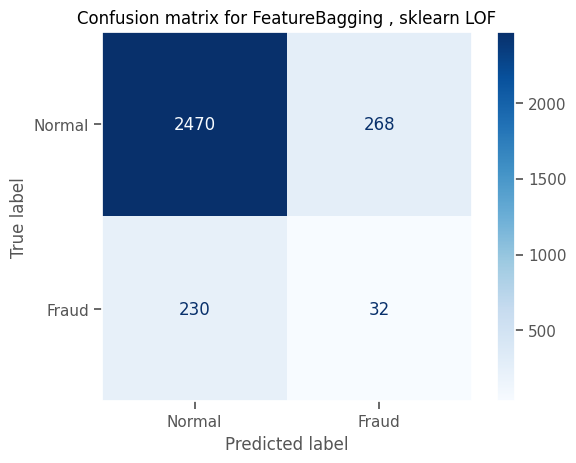

In [59]:
cm2=confusion_matrix(y,ypred2_cm)
fig,ax=plt.subplots()
disp=ConfusionMatrixDisplay(cm2,display_labels=['Normal','Fraud'])
disp.plot(cmap='Blues',ax=ax,colorbar=True)
ax.set_title('Confusion matrix for FeatureBagging , sklearn LOF')
ax.grid(False)
plt.show()

### Visualización

In [65]:
pca=PCA(n_components=2)
X_pca=pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[0.1645074 0.149128 ]


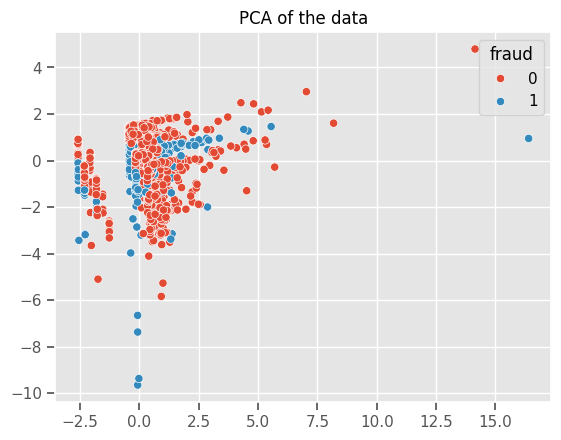

In [67]:
fig,ax=plt.subplots()
sns.scatterplot(x=X_pca[:,0],y=X_pca[:,1],hue=y,ax=ax)
ax.set_title('PCA of the data')
plt.show()

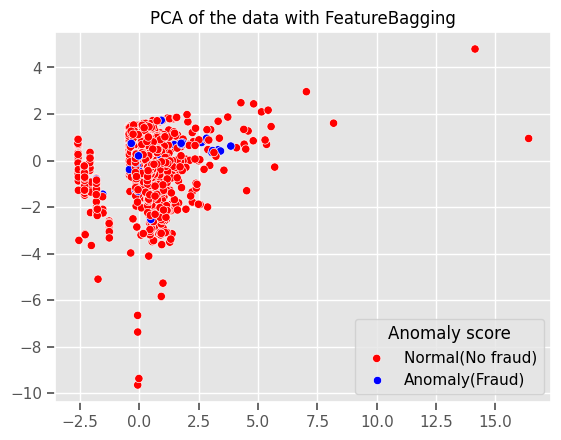

In [77]:
fig,ax=plt.subplots()
sns.scatterplot(x=X_pca[:,0],y=X_pca[:,1],hue=ypred2,ax=ax,palette=['blue','red'])
ax.set_title('PCA of the data with FeatureBagging')
ax.legend(title='Anomaly score',loc='lower right',labels=['Normal(No fraud)','Anomaly(Fraud)'])
plt.show()